In [85]:
from plots8 import *
from plots9 import *
from plots10 import *

import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, Normalize, Pad

from square_sequences import generate_sequences
from image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from StepV4 import StepByStep

# These are the classes we built in Chapter 9
from seq2seq import PositionalEncoding, subsequent_mask, EncoderDecoderSelfAttn

# **Transform and Roll Out!**

## **Narrow Attention**

### **Chunking**

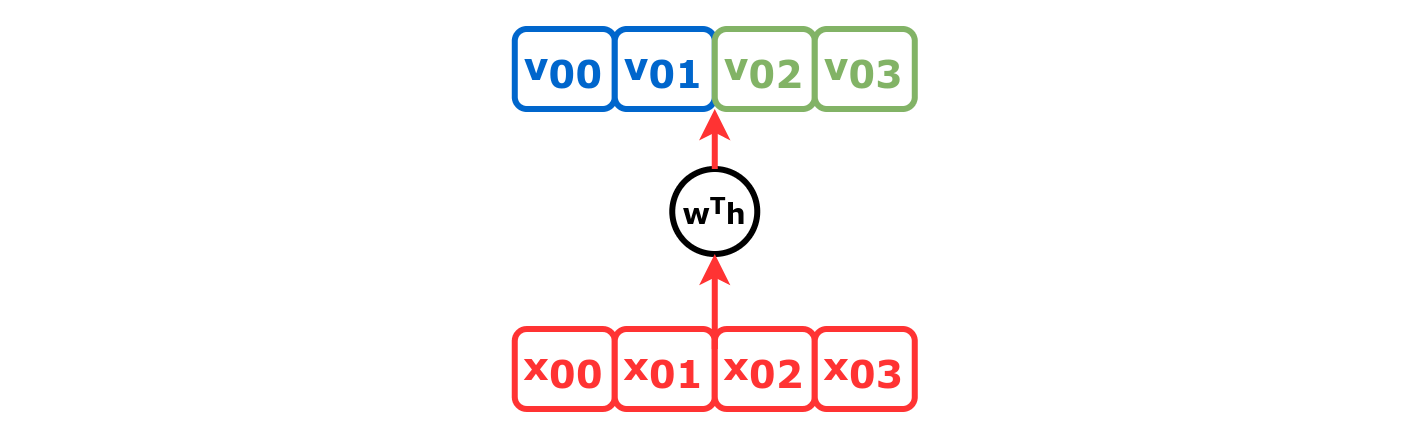

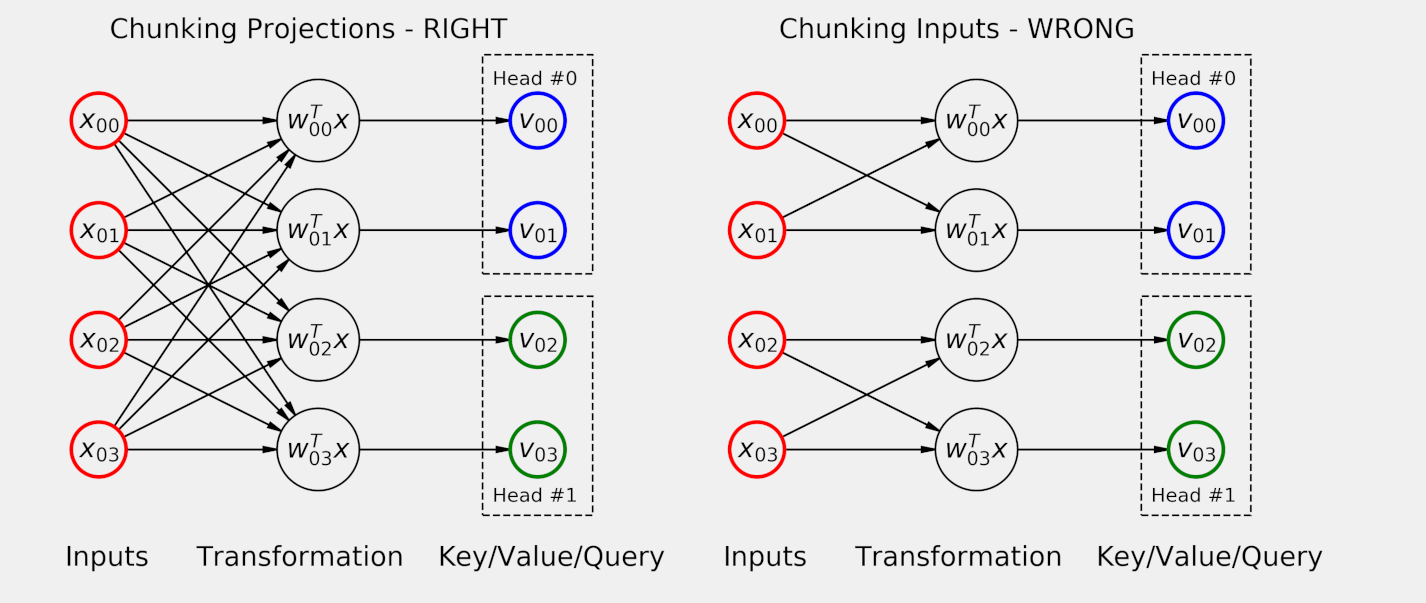

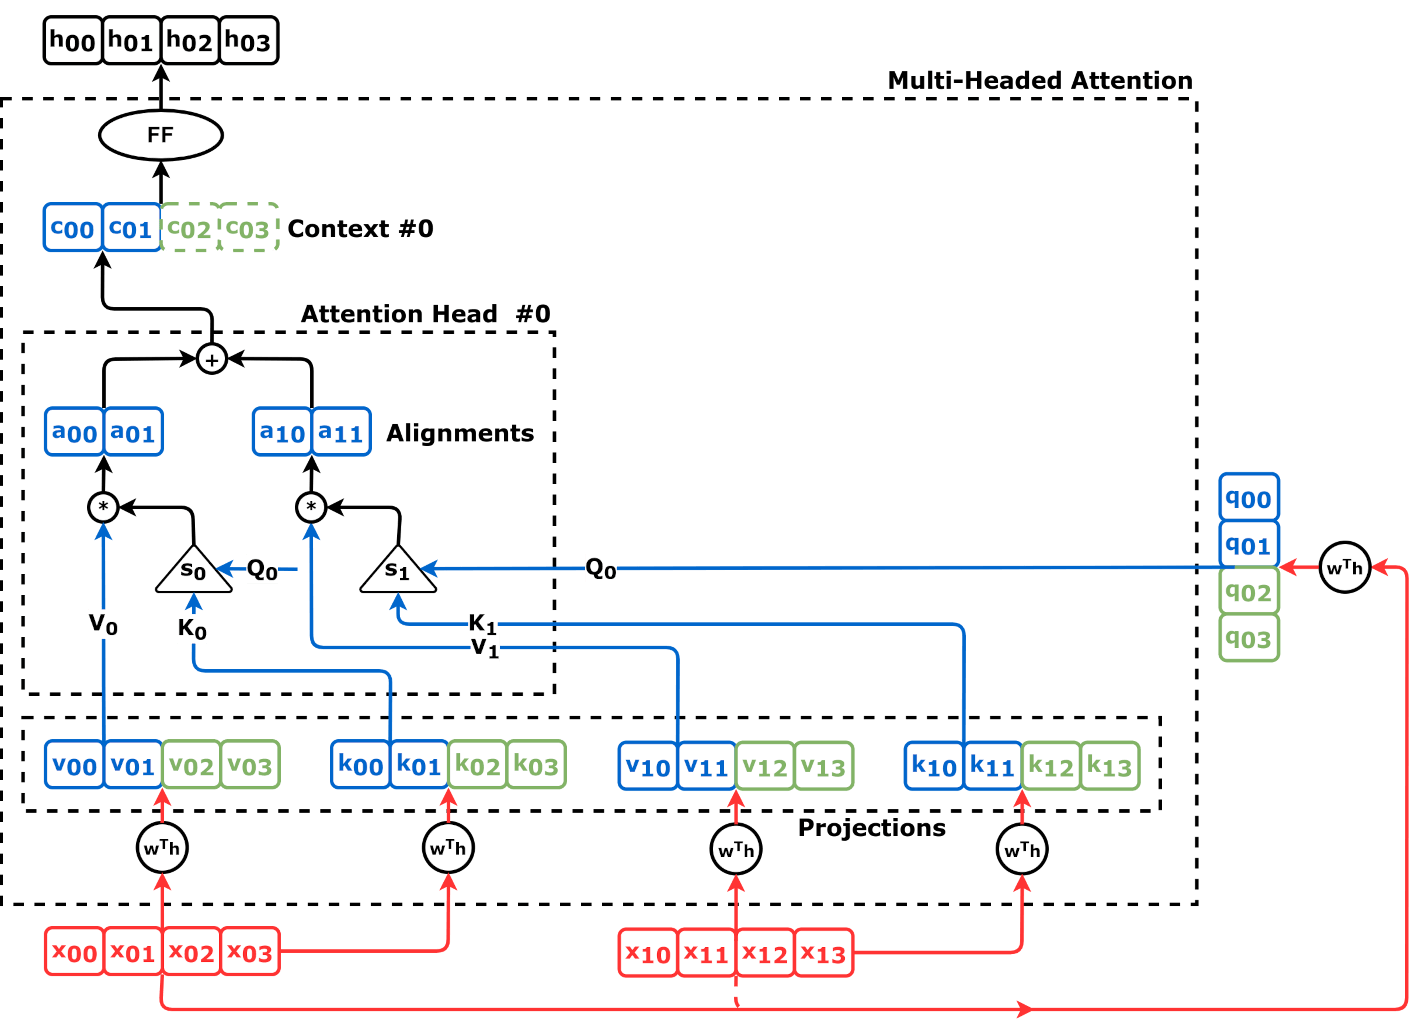

### **Multiheaded Attention**

In [86]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model) # q: c x c matrix
        self.linear_key = nn.Linear(d_model, d_model) # k: c x c matrix
        self.linear_value = nn.Linear(d_model, d_model) # v: c x c matrix
        self.linear_out = nn.Linear(d_model, d_model) # proj_linear c x c matrix 
        self.alphas = None
        
    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        x = x.transpose(1, 2) #[N, L, n_heads * d_k] --> [N, n_heads, L, d_k]
        return x
        
    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))

    def score_funtion(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, self.proj_key.transpose(-2, -1))
        scores = dot_products / np.sqrt(self.d_k)
        return scores

    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_funtion(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()

        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context

    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out

    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

In [87]:
dummy_points = torch.randn(16, 2, 4) # N, L, F
mha = MultiHeadedAttention(n_heads=2, d_model=4, dropout=0.0)
mha.init_keys(dummy_points)
out = mha(dummy_points) # N, L, D
out.shape

torch.Size([16, 2, 4])

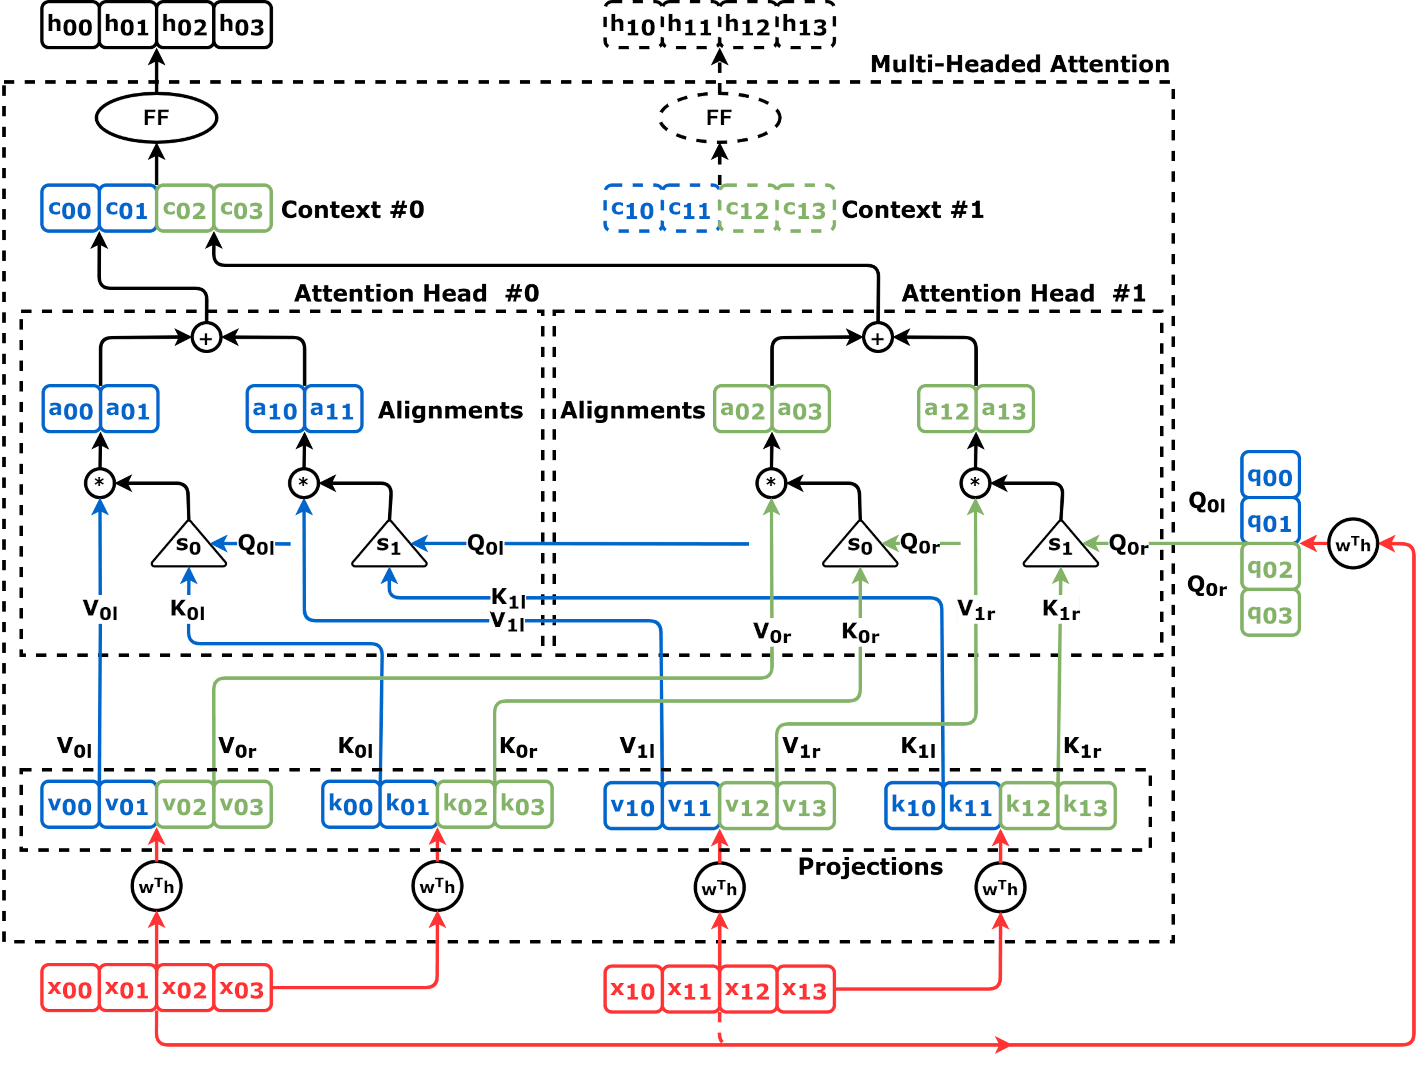

## **Stacking Encoders and Decoders**

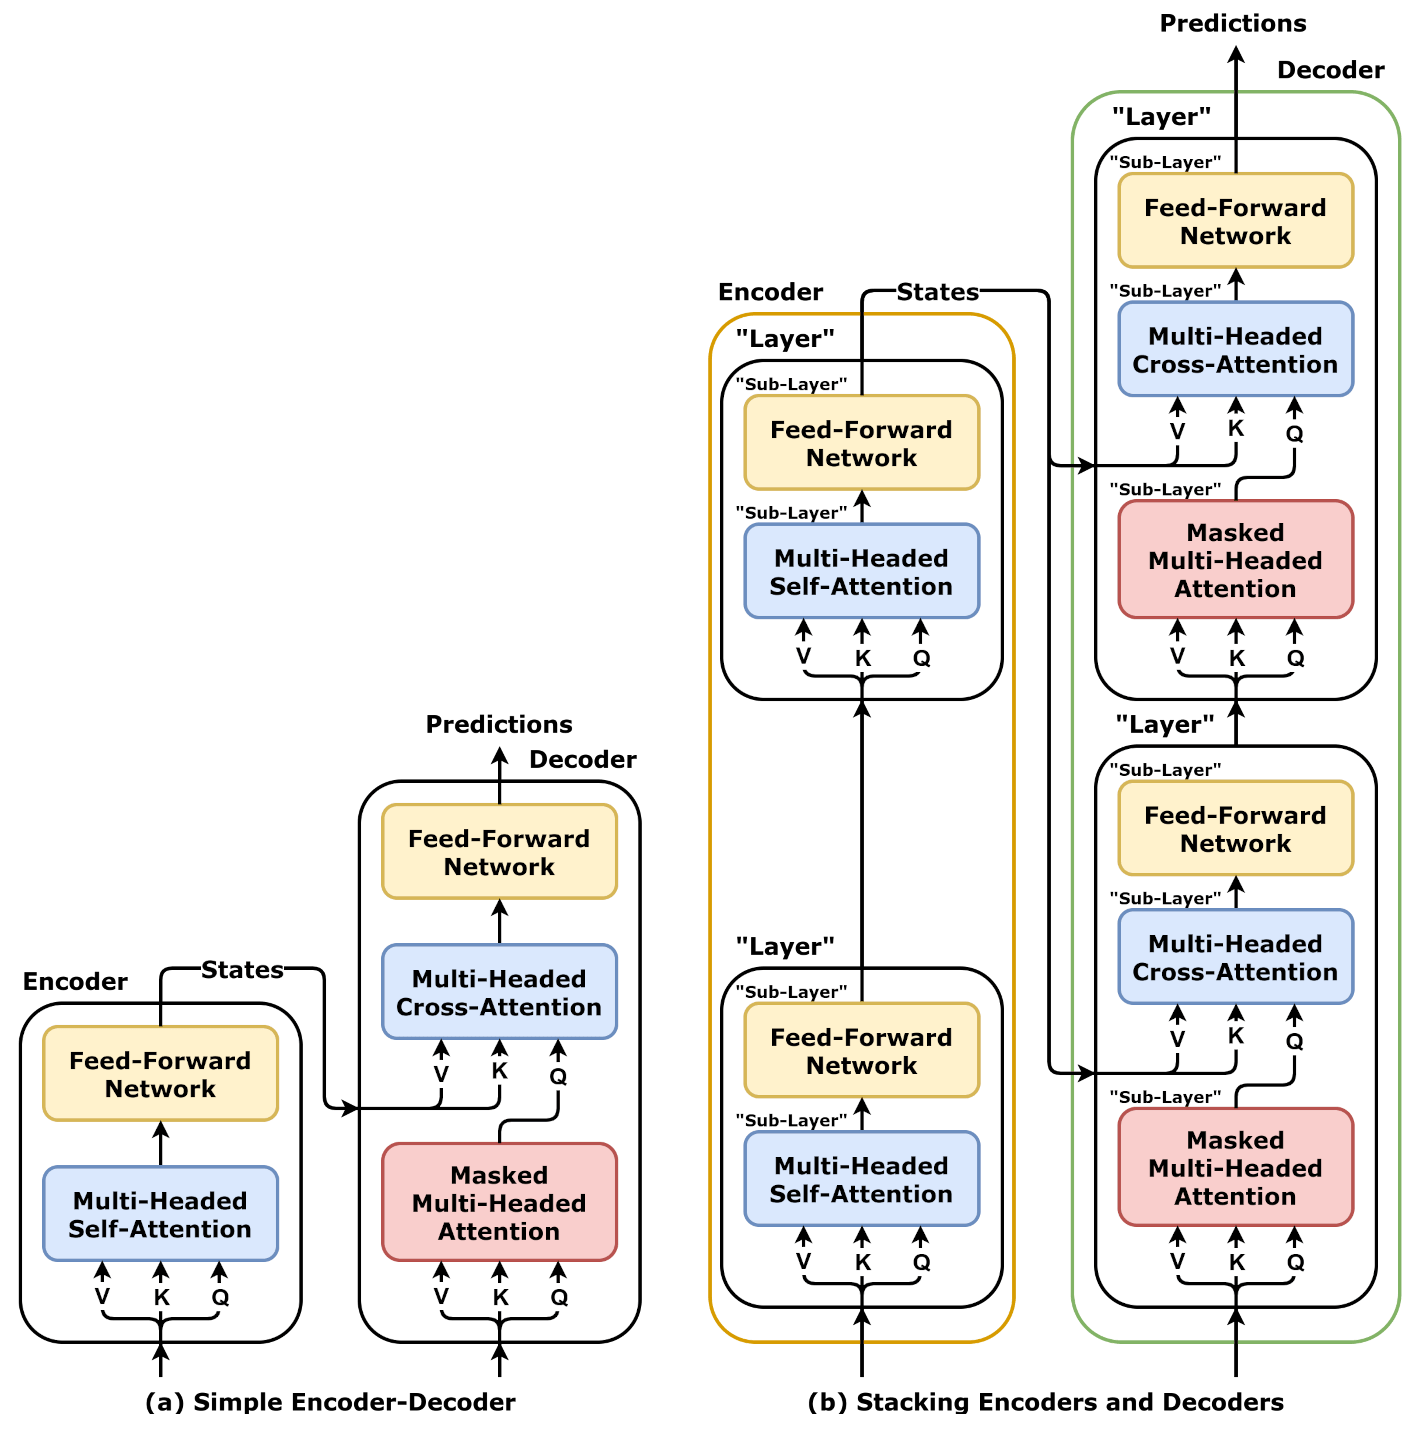

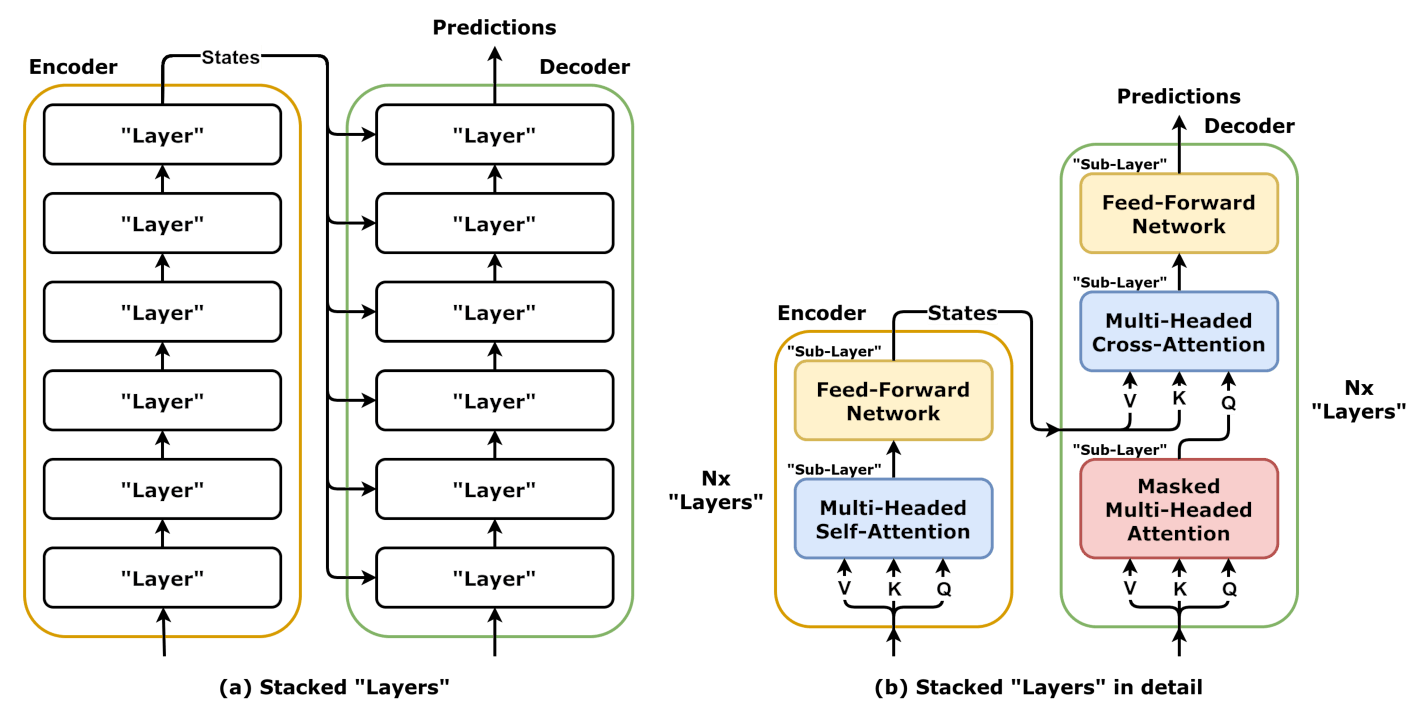

## **Wrapping "Sub-Layers"**

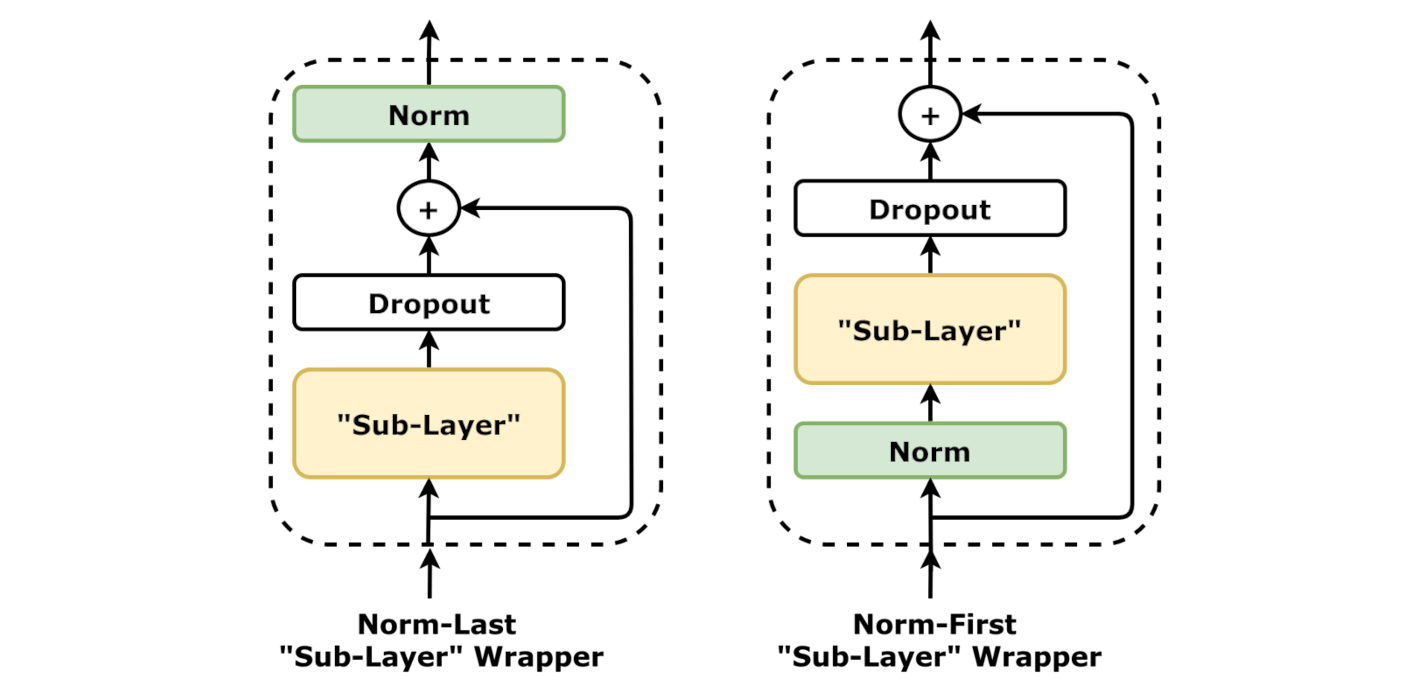

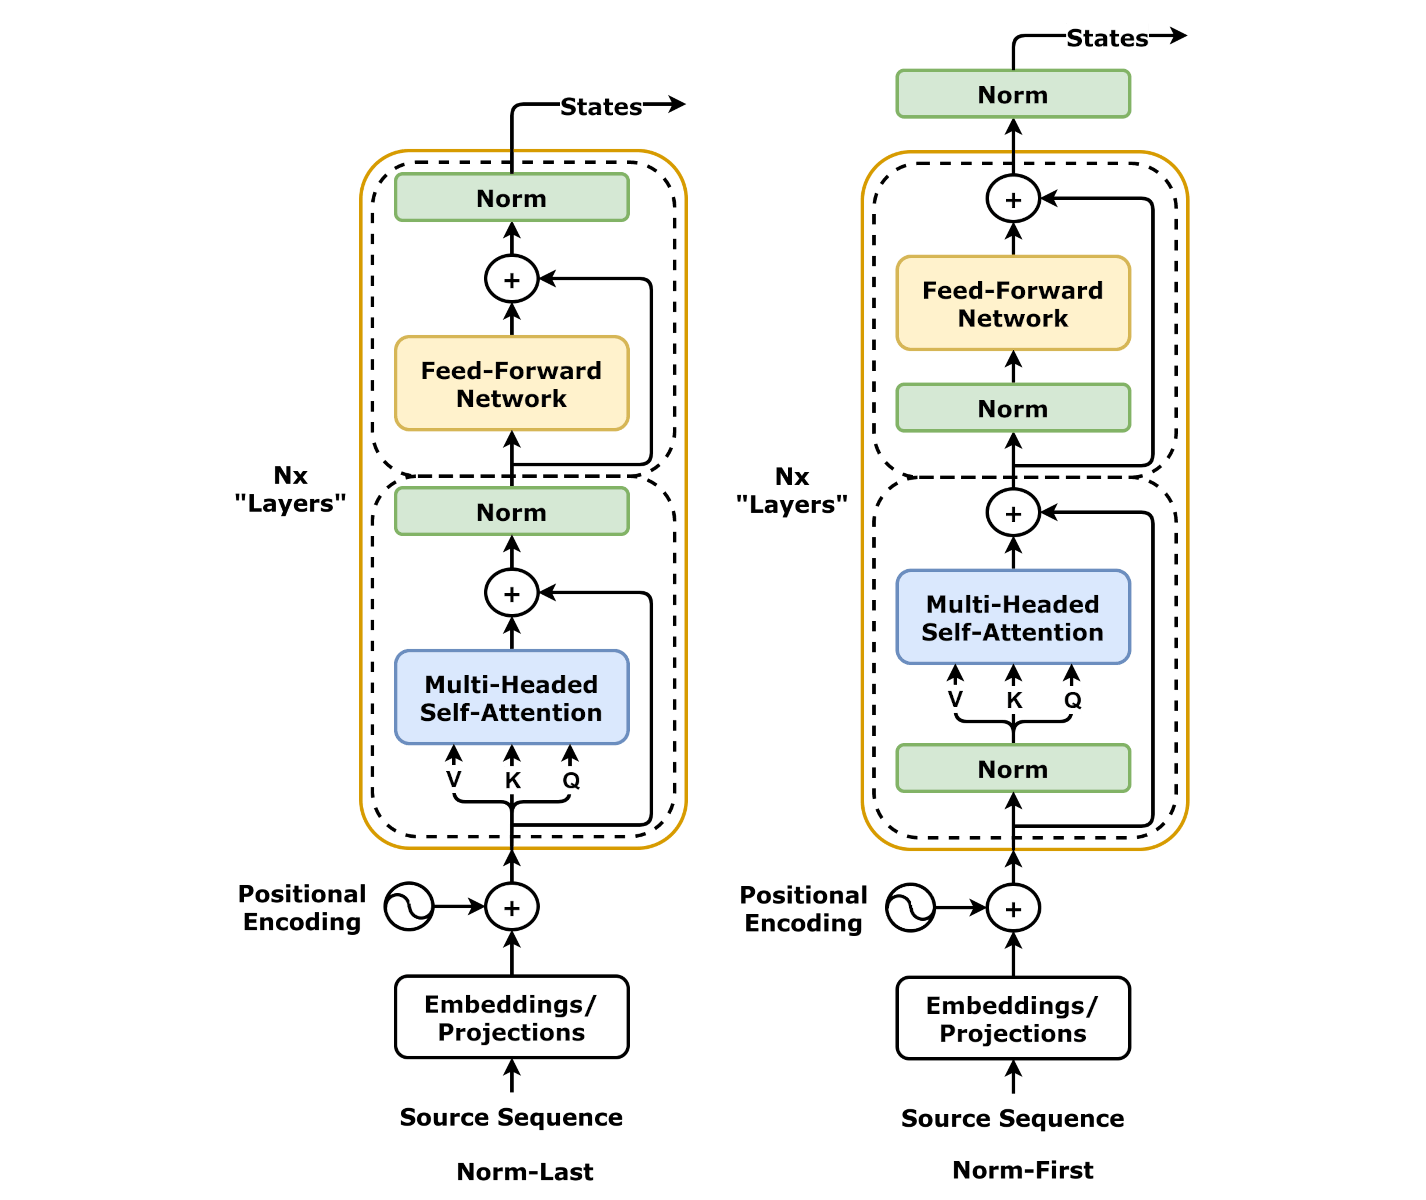

In [88]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)

        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [89]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

In [90]:
enclayer = nn.TransformerEncoderLayer(d_model=6, nhead=3, dim_feedforward=20)
enctransf = nn.TransformerEncoder(enclayer, num_layers=1, norm=nn.LayerNorm)

## **Transformer Decoder**

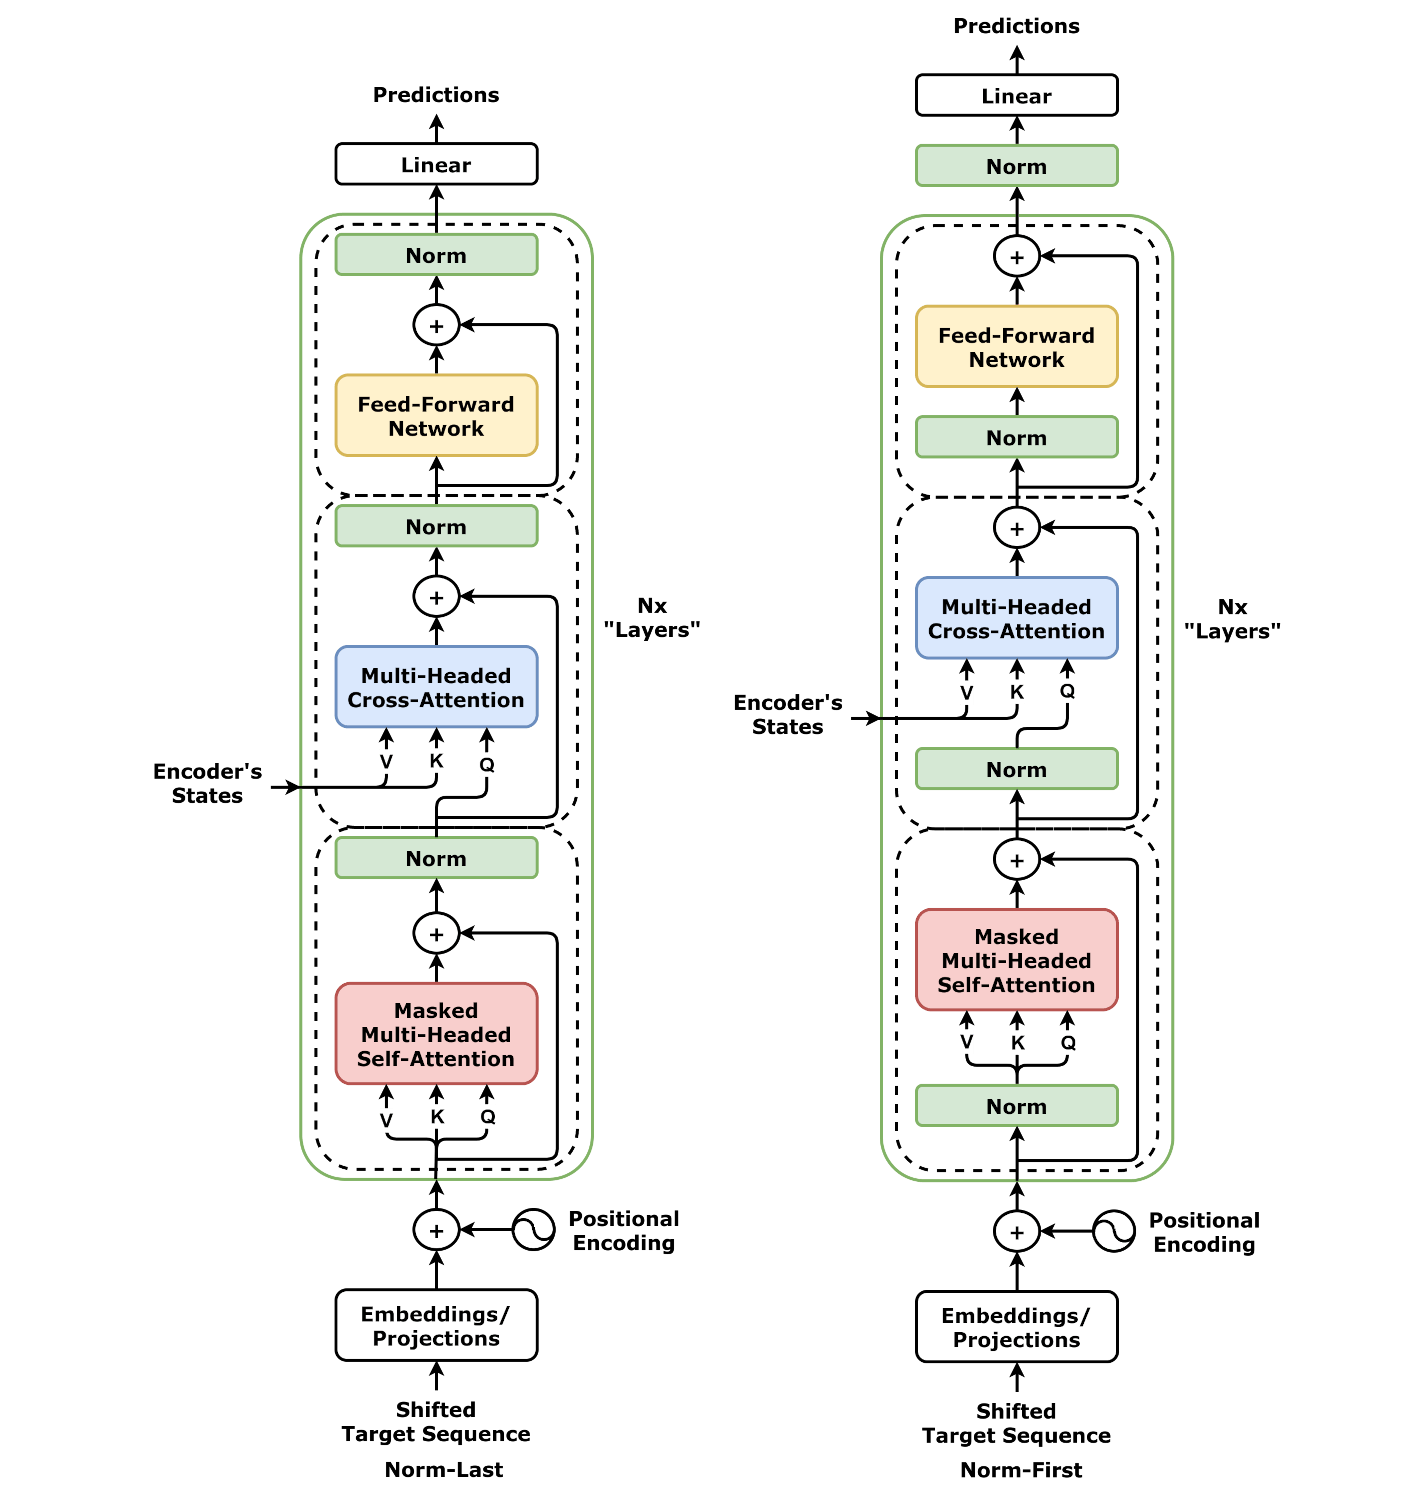

In [91]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units

        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model)
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Masked Multi-head Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, target_mask)
        # Add
        att1 = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att1 = self.norm2(att1)
        # Multi-head Attention
        encoder_states = self.cross_attn_heads(norm_att1, source_mask)
        # Add
        att2 = att1 + self.drop2(encoder_states)
        
        # Sublayer #2
        # Norm
        norm_att2 = self.norm3(att2)
        # Feed Forward
        out = self.ffn(norm_att2)
        # Add
        out = att2 + self.drop3(out)
        return out

In [92]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])
        
    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

In [93]:
declayer = nn.TransformerDecoderLayer(d_model=6, nhead=3, dim_feedforward=20)
dectransf = nn.TransformerDecoder(declayer, num_layers=1, norm=nn.LayerNorm)

## **Layer Normalization**

In [94]:
d_model = 4
seq_len = 2
n_points = 3

torch.manual_seed(34)
data = torch.randn(n_points, seq_len, d_model)
pe = PositionalEncoding(seq_len, d_model)
inputs = pe(data)
inputs

tensor([[[-3.8049,  1.9899, -1.7325,  2.1359],
         [ 1.7854,  0.8155,  0.1116, -1.7420]],

        [[-2.4273,  1.3559,  2.8615,  2.0084],
         [-1.0353, -1.2766, -2.2082, -0.6952]],

        [[-0.8044,  1.9707,  3.3704,  2.0587],
         [ 4.2256,  6.9575,  1.4770,  2.0762]]])

In [95]:
inputs_mean = inputs.mean(axis=2).unsqueeze(2)
inputs_mean

tensor([[[-0.3529],
         [ 0.2426]],

        [[ 0.9496],
         [-1.3038]],

        [[ 1.6489],
         [ 3.6841]]])

In [96]:
inputs_var = inputs.var(axis=2, unbiased=False).unsqueeze(2)
inputs_var

tensor([[[6.3756],
         [1.6661]],

        [[4.0862],
         [0.3153]],

        [[2.3135],
         [4.6163]]])

In [97]:
(inputs - inputs_mean)/torch.sqrt(inputs_var+1e-5)

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]])

In [98]:
layer_norm = nn.LayerNorm(d_model)
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

In [99]:
layer_norm = nn.LayerNorm(d_model)
normalized = layer_norm(inputs)

normalized[0][0].mean(), normalized[0][0].std(unbiased=False)

(tensor(-1.4901e-08, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward0>))

In [100]:
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

### **Batch vs Layer**

In [101]:
torch.manual_seed(23)
dummy_points = torch.randn(4, 1, 256)
dummy_pe = PositionalEncoding(1, 256)
dummy_enc = dummy_pe(dummy_points)
dummy_enc

tensor([[[-14.4193,  10.0495,  -7.8116,  ..., -15.4844, -18.0732,  -3.9566]],

        [[  2.6628,  -3.5462, -23.6461,  ...,  -0.9403, -18.4375, -37.4197]],

        [[-24.6397,  -1.9127, -16.4244,  ..., -17.3708, -26.0550, -14.0706]],

        [[ 13.7988,  21.4612,  10.4125,  ...,  -3.2333, -17.0188,   3.9237]]])

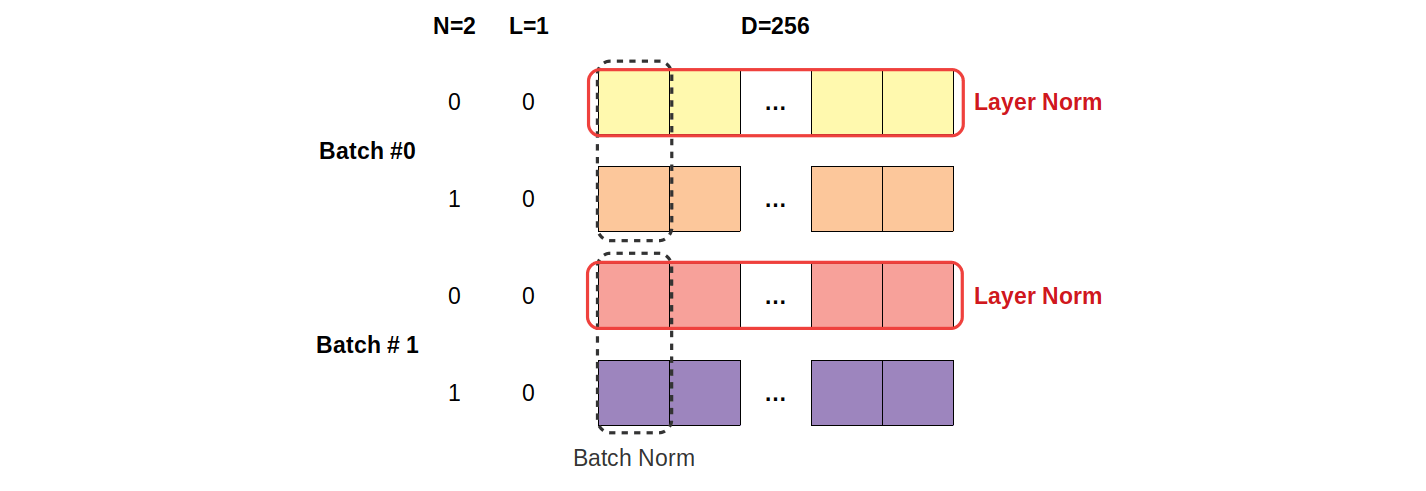

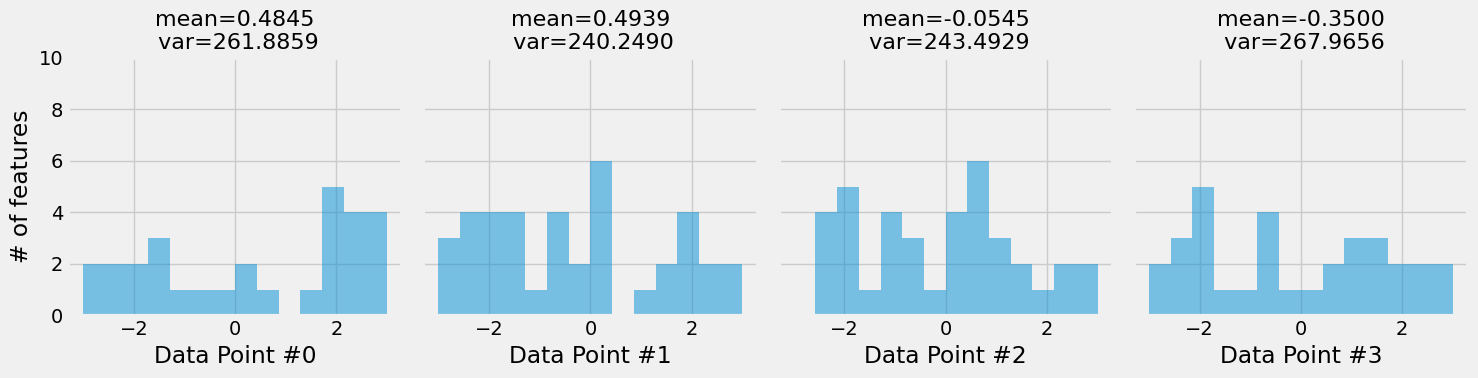

In [102]:
fig = hist_encoding(dummy_enc)

In [103]:
layer_normalizer = nn.LayerNorm(256)
dummy_normed = layer_normalizer(dummy_enc)
dummy_normed

tensor([[[-0.9210,  0.5911, -0.5127,  ..., -0.9868, -1.1467, -0.2744]],

        [[ 0.1399, -0.2607, -1.5574,  ..., -0.0925, -1.2214, -2.4460]],

        [[-1.5755, -0.1191, -1.0491,  ..., -1.1097, -1.6662, -0.8982]],

        [[ 0.8643,  1.3324,  0.6575,  ..., -0.1761, -1.0183,  0.2611]]],
       grad_fn=<NativeLayerNormBackward0>)

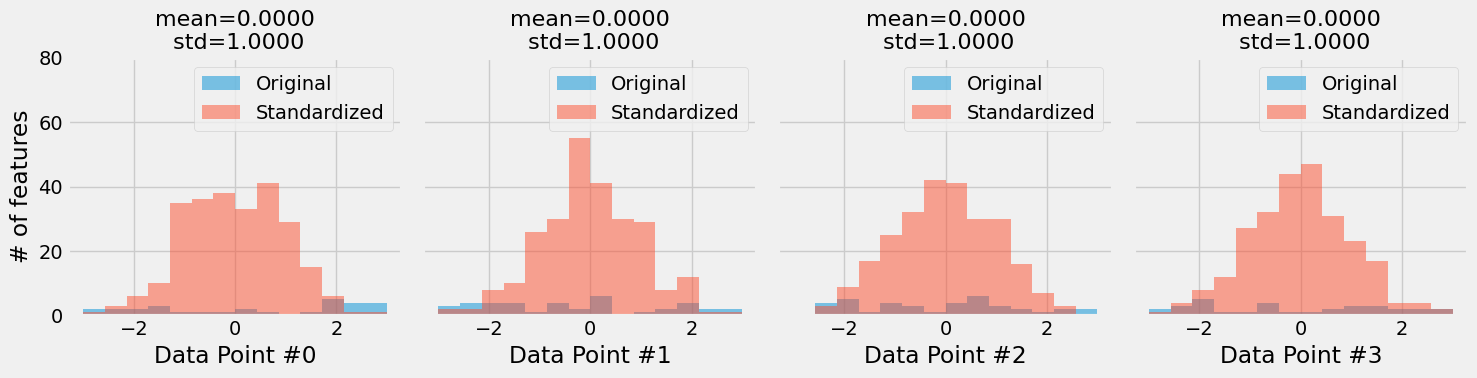

In [104]:
fig = hist_layer_normed(dummy_enc, dummy_normed)


### **Our Seq2Seq Problem**

In [105]:
pe = PositionalEncoding(max_len=2, d_model=2)

source_seq = torch.tensor([[[ 1.0349,  0.9661], [ 0.8055, -0.9169]]])
source_seq_enc = pe(source_seq)
source_seq_enc

tensor([[[ 1.4636,  2.3663],
         [ 1.9806, -0.7564]]])

In [106]:
norm = nn.LayerNorm(2)
norm(source_seq_enc)

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

### **Projections or Embeddings**

In [107]:
torch.manual_seed(11)
proj_dim = 6
linear_proj = nn.Linear(2, proj_dim)
pe = PositionalEncoding(2, proj_dim)

source_seq_proj = linear_proj(source_seq)
source_seq_proj_enc = pe(source_seq_proj)
source_seq_proj_enc

tensor([[[-2.0934,  1.5040,  1.8742,  0.0628,  0.3034,  2.0190],
         [-0.8853,  2.8213,  0.5911,  2.4193, -2.5230,  0.3599]]],
       grad_fn=<AddBackward0>)

In [108]:
norm = nn.LayerNorm(proj_dim)
norm(source_seq_proj_enc)

tensor([[[-1.9061,  0.6287,  0.8896, -0.3868, -0.2172,  0.9917],
         [-0.7362,  1.2864,  0.0694,  1.0670, -1.6299, -0.0568]]],
       grad_fn=<NativeLayerNormBackward0>)

### **The Transformer**

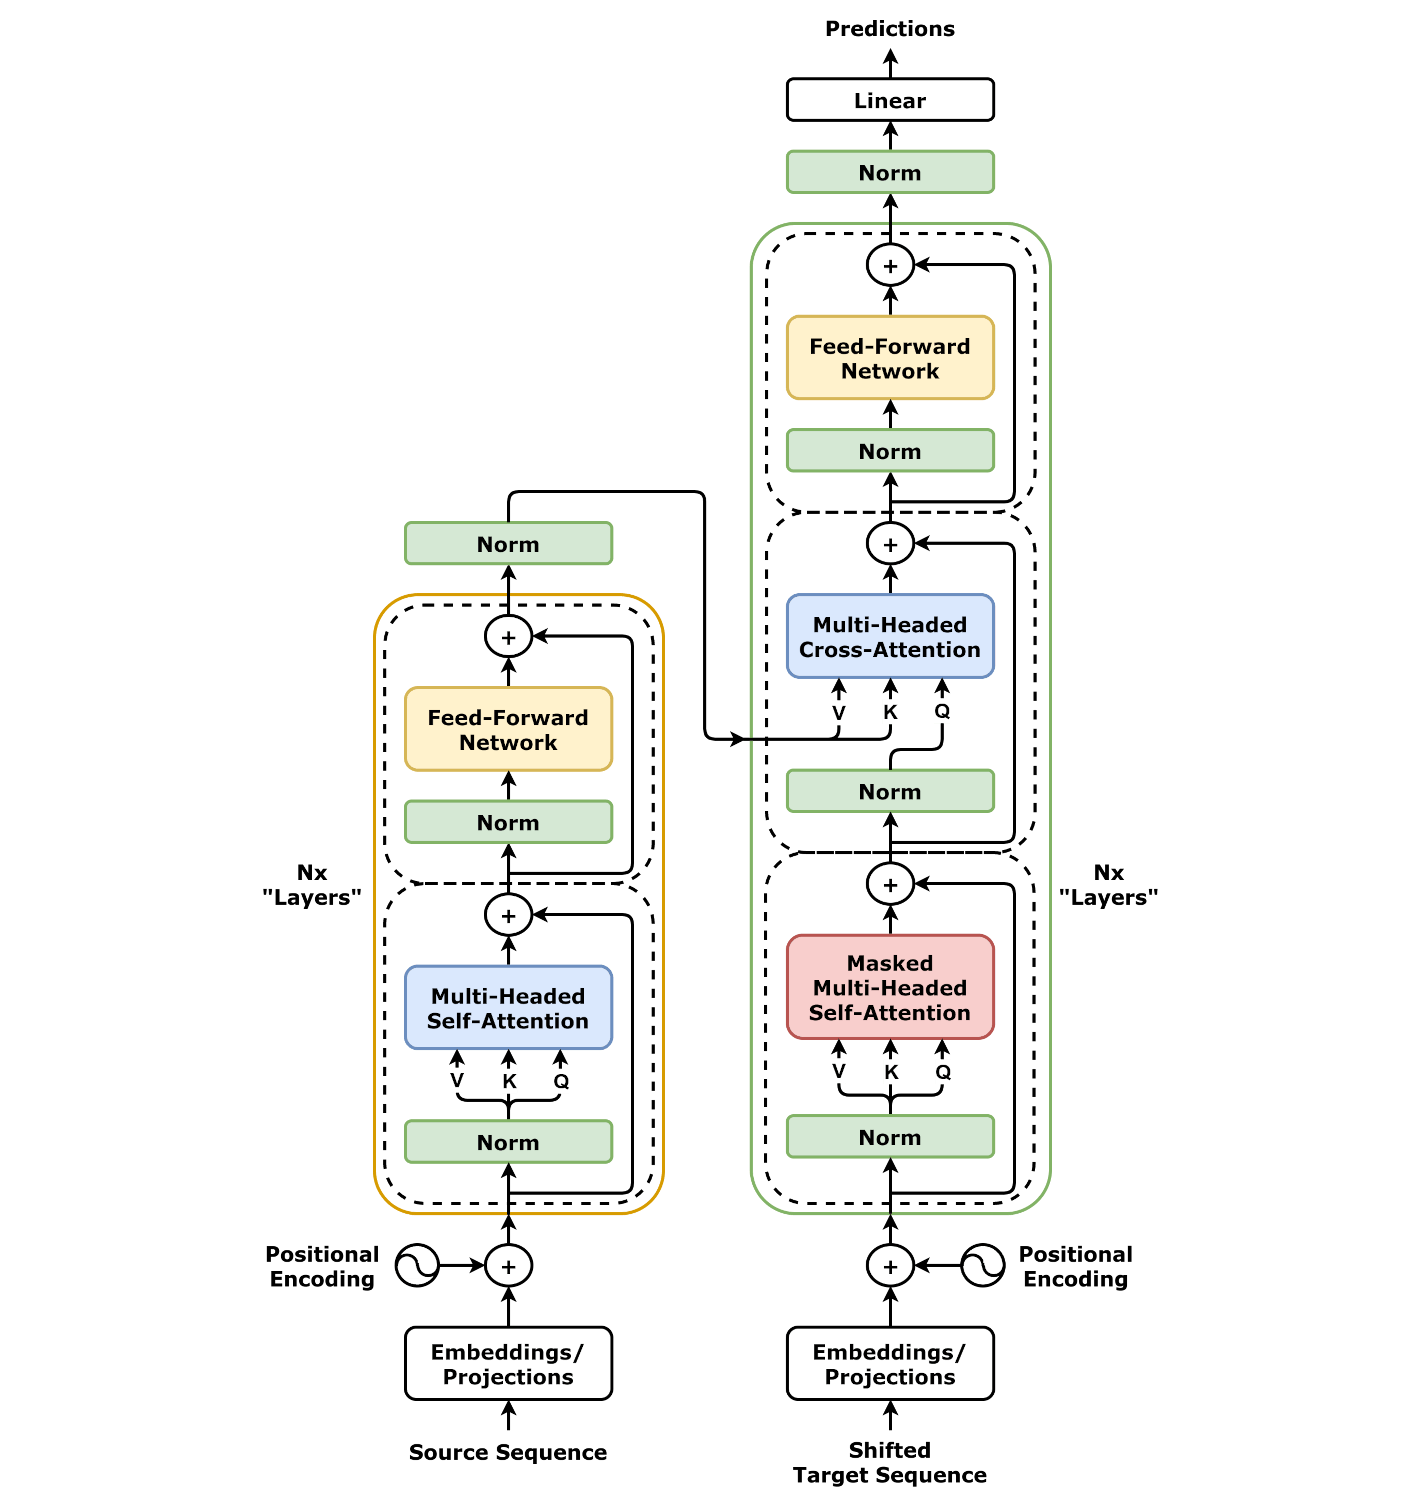

In [109]:
class EncoderDecoderTransf(EncoderDecoderSelfAttn):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__(encoder, decoder, input_len, target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

In [110]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super(EncoderDecoderSelfAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequence_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### **Data Preparation***

In [111]:
# Generating training data
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
# Generating test data
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
# Datasets and data loaders
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

In [112]:
example = next(iter(train_loader))

In [113]:
for X in example:
    print(X.size())
    break

torch.Size([16, 4, 2])


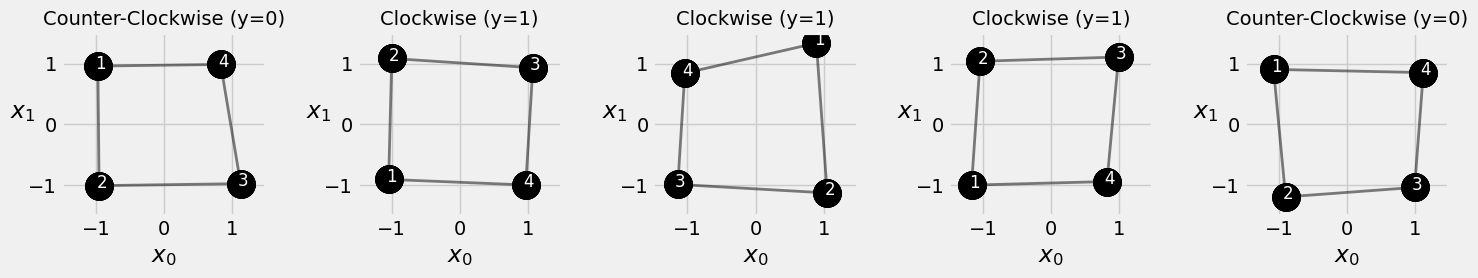

In [114]:
fig = plot_data(points, directions, n_rows=1)

### **Model Configuration & Training**

In [115]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [116]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [117]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

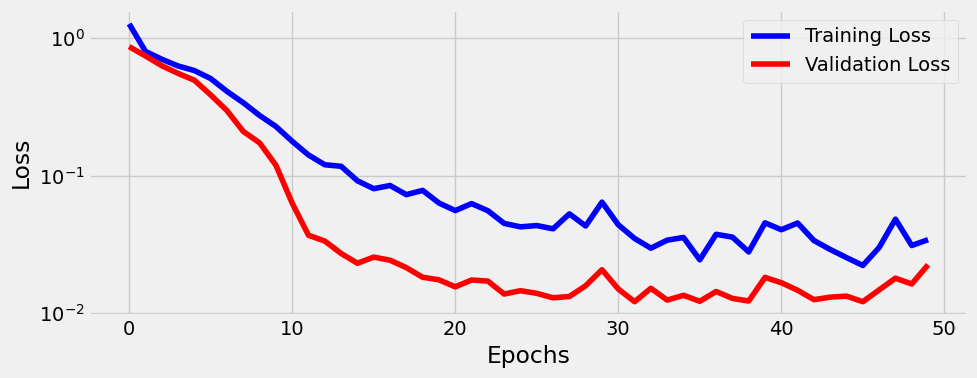

In [118]:
fig = sbs_seq_transf.plot_losses()

In [119]:
torch.manual_seed(11)
x, y = next(iter(train_loader))
device = sbs_seq_transf.device
# Training
model_transf.train()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)

In [120]:
# Validation
model_transf.eval()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0234, device='cuda:0')

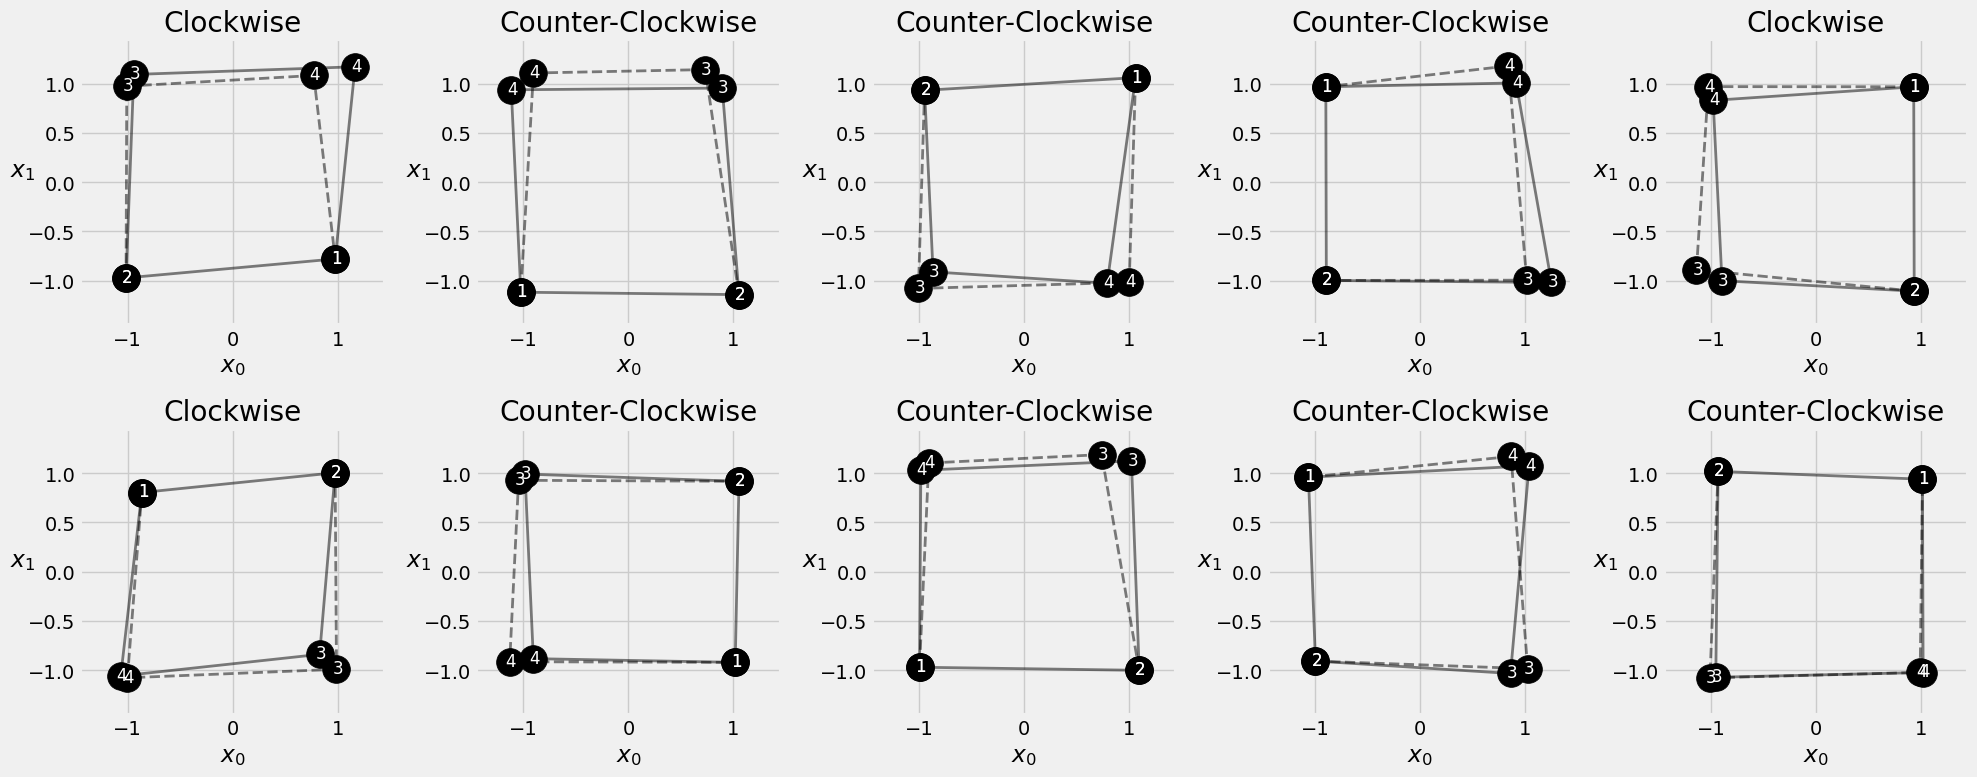

In [121]:
fig = sequence_pred(sbs_seq_transf, full_test, test_directions)

## **The PyTorch Transformer**

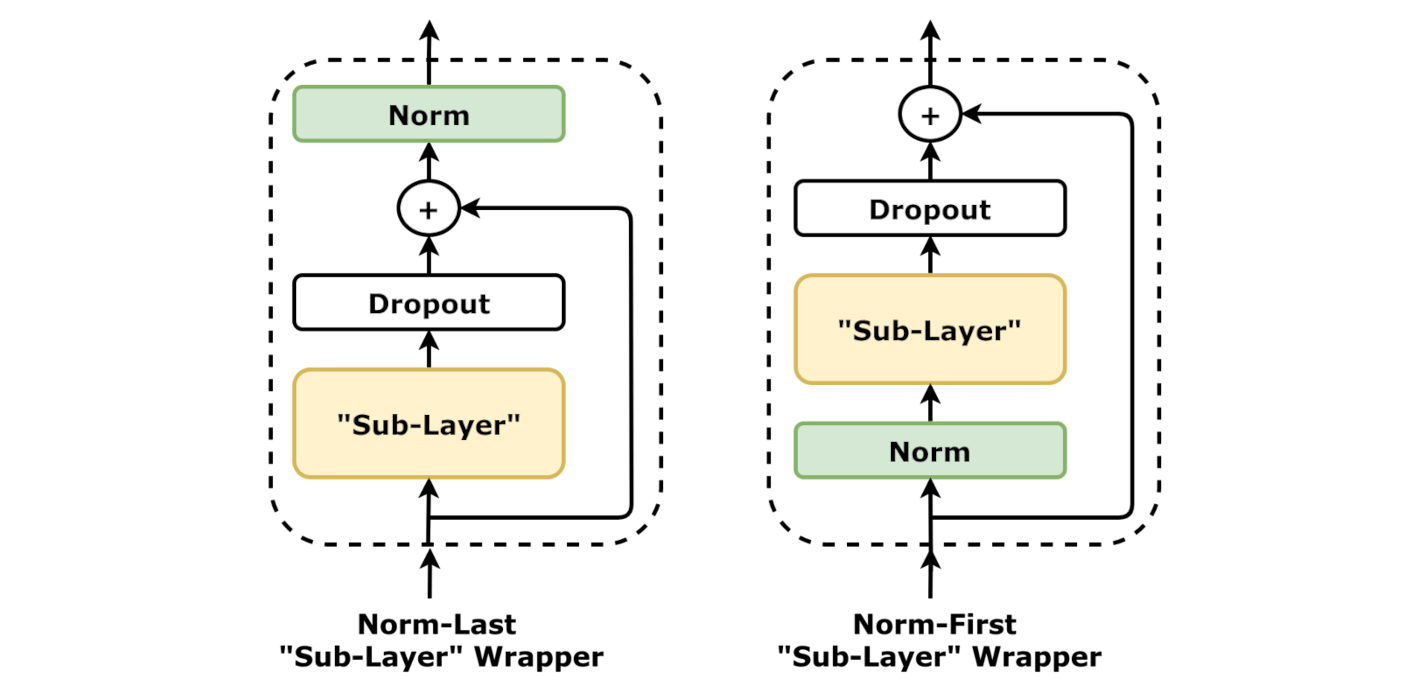

In [122]:
def encode_decode(self, source, target, source_mask=None, target_mask=None):
    # Projections
    # PyTorch Transformer expects L, N, F
    src = self.preprocess(source).permute(1, 0, 2)
    tgt = self.preprocess(target).permute(1, 0, 2)

    out = self.transf(src, tgt, 
                      src_key_padding_mask=source_mask, 
                      tgt_mask=target_mask)

    # Linear
    # Back to N, L, D
    out = out.permute(1, 0, 2)
    out = self.linear(out) # N, L, F
    return out

In [123]:
class TransformerModel(nn.Module):
    def __init__(self, transformer, input_len, target_len, n_features):
        super().__init__()
        self.transf = transformer
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.transf.generate_square_subsequent_mask(self.target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, self.transf.d_model)
        self.linear = nn.Linear(self.transf.d_model, n_features)
        
        max_len = max(self.input_len, self.target_len)
        self.pe = PositionalEncoding(max_len, self.transf.d_model)
        self.norm = nn.LayerNorm(self.transf.d_model)
                
    def preprocess(self, seq):
        seq_proj = self.proj(seq)
        seq_enc = self.pe(seq_proj)
        return self.norm(seq_enc)
    
    def encode_decode(self, source, target, source_mask=None, target_mask=None):
        # Projections
        # PyTorch Transformer expects L, N, F
        src = self.preprocess(source).permute(1, 0, 2)
        tgt = self.preprocess(target).permute(1, 0, 2)

        out = self.transf(src, tgt, 
                          src_key_padding_mask=source_mask, 
                          tgt_mask=target_mask)

        # Linear
        # Back to N, L, D
        out = out.permute(1, 0, 2)
        out = self.linear(out) # N, L, F
        return out
        
    def predict(self, source_seq, source_mask=None):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.encode_decode(source_seq, inputs, 
                                     source_mask=source_mask,
                                     target_mask=self.trg_masks[:i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = out[:, 1:, :]
        return outputs


    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X)
        source_seq = X[:, :self.input_len, :]
        
        if self.training:            
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.encode_decode(source_seq, shifted_target_seq, 
                                         source_mask=source_mask, 
                                         target_mask=self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### **Model Configuration & Training**

In [124]:
torch.manual_seed(42)
transformer = nn.Transformer(d_model=6, nhead=3, 
                             num_encoder_layers=1, num_decoder_layers=1,
                             dim_feedforward=20, dropout=0.1)
model_transformer = TransformerModel(transformer, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)

In [125]:
for p in model_transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [126]:
sbs_seq_transformer = StepByStep(model_transformer, loss, optimizer)
sbs_seq_transformer.set_loaders(train_loader, test_loader)
sbs_seq_transformer.train(50)

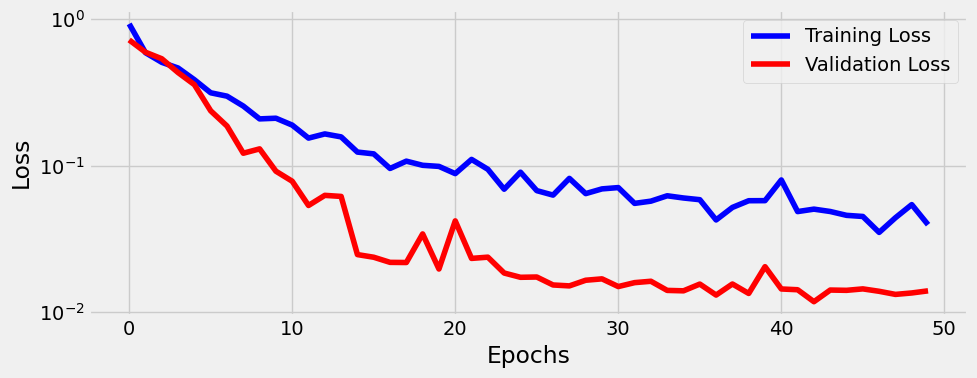

In [127]:
fig = sbs_seq_transformer.plot_losses()

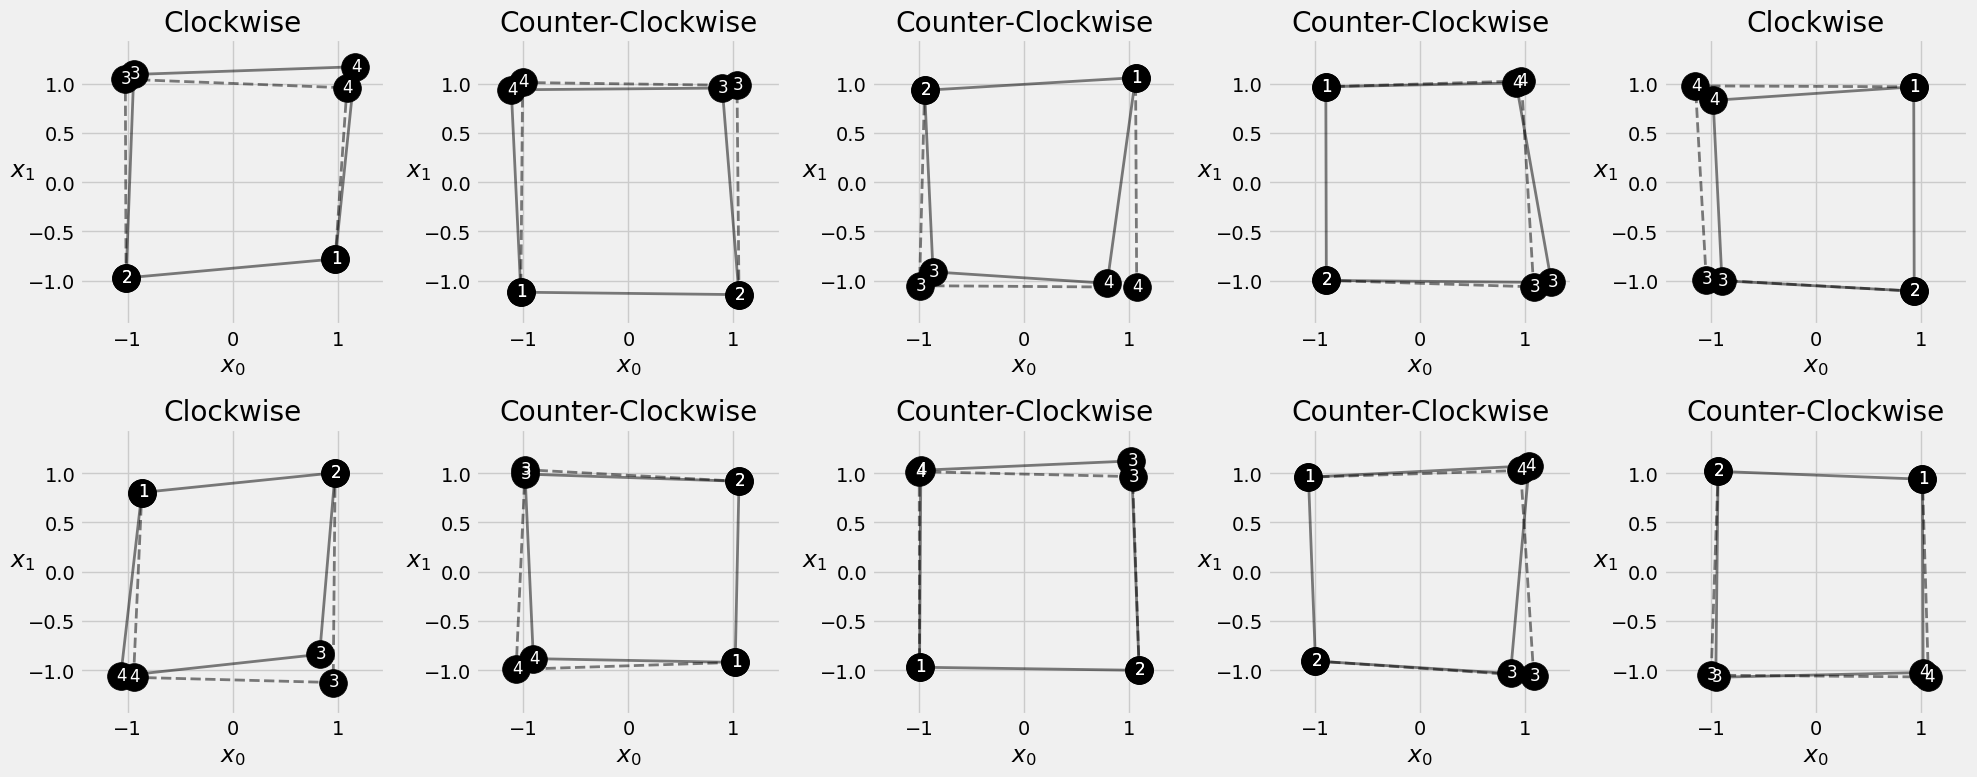

In [128]:
fig = sequence_pred(sbs_seq_transformer, full_test, test_directions)

# **Vision Transformer**
(https://github.com/jiaowoguanren0615/DL_ML/tree/main/Deep_learning/classification/ViT)

In [129]:
# https://github.com/jiaowoguanren0615/DL_ML/tree/main/Deep_learning/classification/ViT

# **Putting It All Together**

In [130]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

## **Model Assembly**

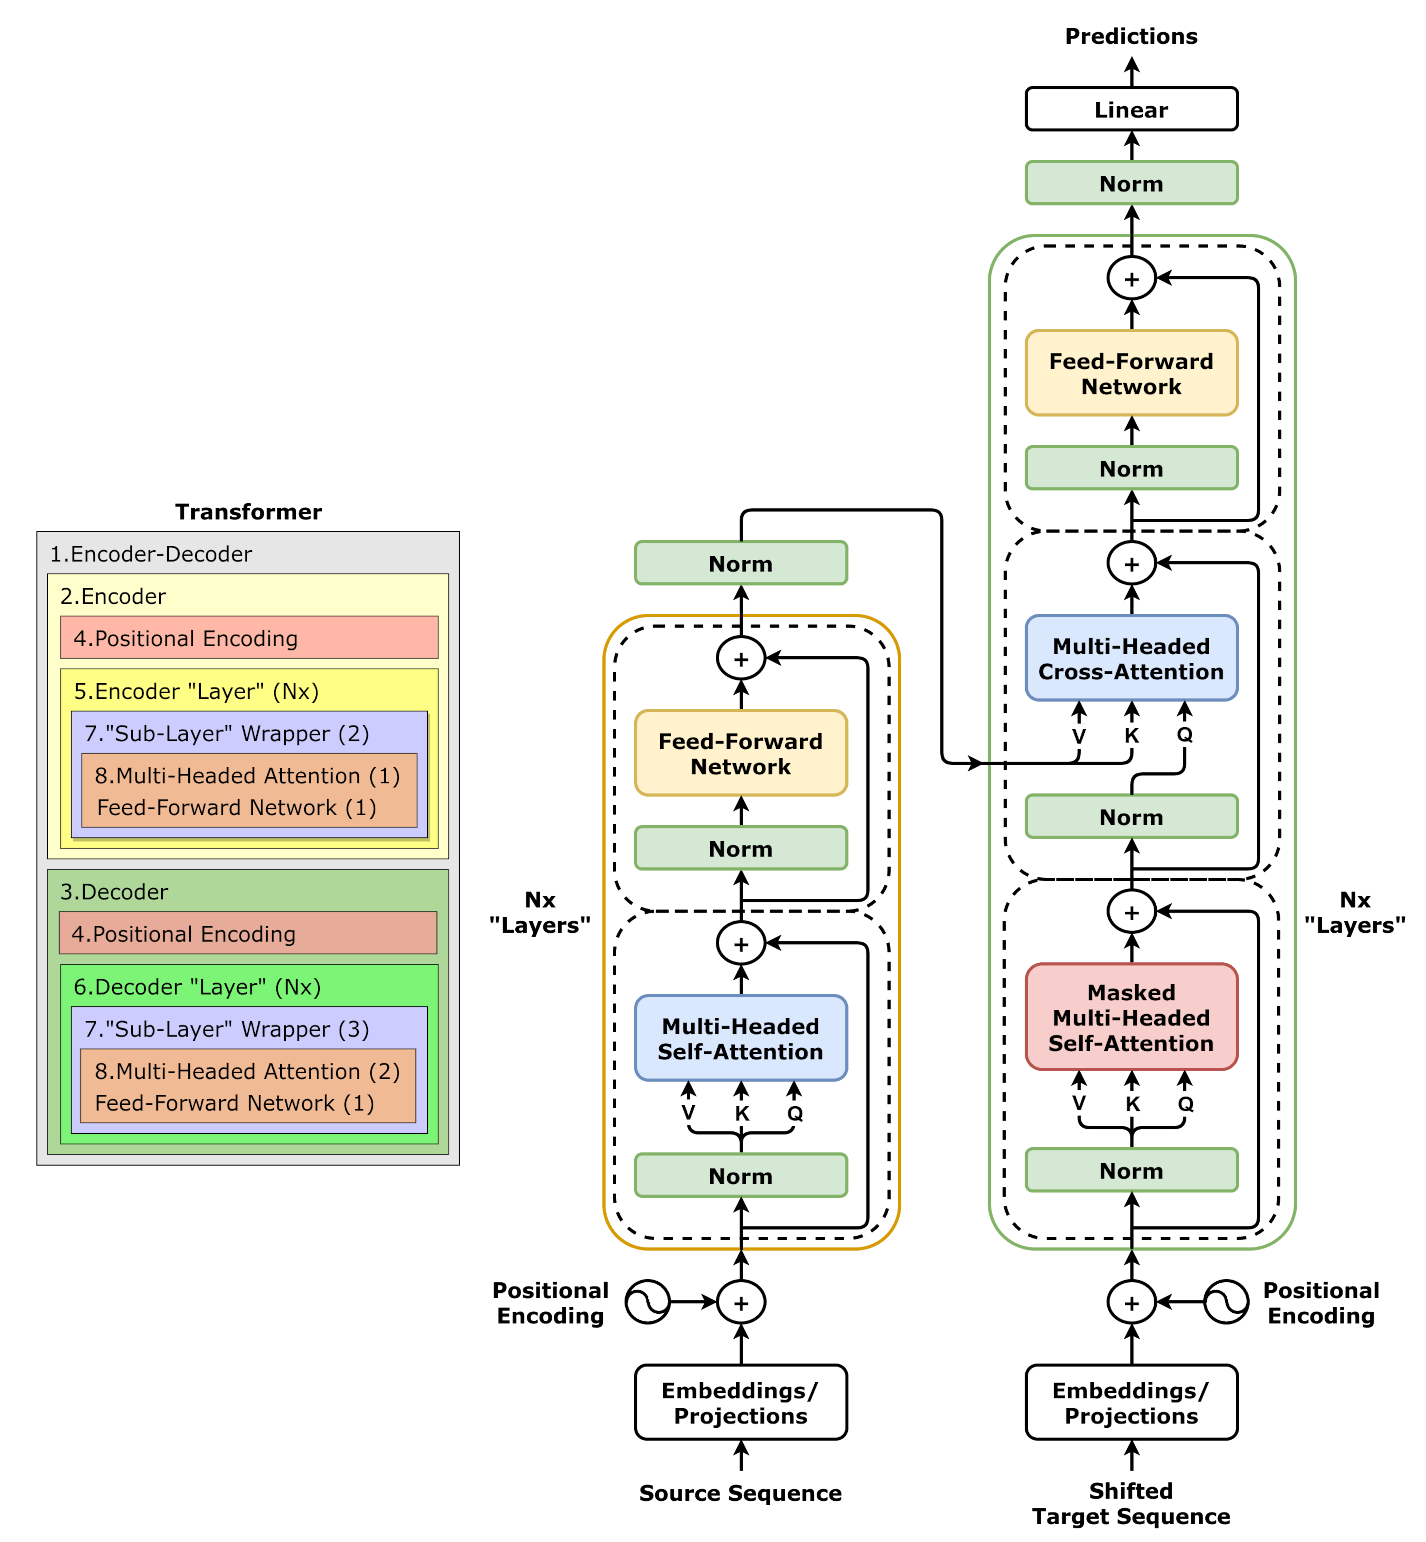

### **1. Encoder-Decoder**

In [131]:
class EncoderDecoderTransf(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)
            
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)    
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs
    
    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### **2. Encoder**

In [132]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

### **3. Decoder**

In [133]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])
        
    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

### **4. Positional Encoding**

In [134]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        slope = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * slope) # even dimensions
        pe[:, 1::2] = torch.cos(position * slope) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

### **5. Encoder "Layer"**

In [135]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(2)])
         
    def forward(self, query, mask=None):
        # SubLayer 0 - Self-Attention
        att = self.sublayers[0](query,
                                sublayer=self.self_attn_heads, 
                                is_self_attn=True,
                                mask=mask)
        # SubLayer 1 - FFN
        out = self.sublayers[1](att, sublayer=self.ffn)
        return out

### **6. Decoder "Layer"**

In [136]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(3)])
                
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        # SubLayer 0 - Masked Self-Attention
        att1 = self.sublayers[0](query, 
                                 sublayer=self.self_attn_heads, 
                                 is_self_attn=True, 
                                 mask=target_mask)
        # SubLayer 1 - Cross-Attention
        att2 = self.sublayers[1](att1, 
                                 sublayer=self.cross_attn_heads, 
                                 mask=source_mask)
        # SubLayer 2 - FFN
        out = self.sublayers[2](att2, sublayer=self.ffn)
        return out

### **7. "SubLayer" Wrapper**

In [137]:
class SubLayerWrapper(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x, sublayer, is_self_attn=False, **kwargs):
        norm_x = self.norm(x)
        if is_self_attn:
            sublayer.init_keys(norm_x)
        out = x + self.drop(sublayer(norm_x, **kwargs))
        return out

In [138]:
# Before
def forward(self, query, mask=None):
    # query and mask go in
    norm_query = self.norm1(query)
    self.self_attn_heads.init_keys(norm_query)
    # the sublayer is the self-attention
    states = self.self_attn_heads(norm_query, mask)
    att = query + self.drop1(states)
    # att comes out
    ...
    
# After
def forward(self, query, mask=None):
    # query and mask go in
    # the sublayer is the self-attention
    # norm, drop, and residual are inside the wrapper
    att = self.sublayers[0](query,
                            sublayer=self.self_attn_heads, 
                            is_self_attn=True,
                            mask=mask)
    # att comes out
    ...

### **8. Multi-Headed Attention**

In [139]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context


    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

## **Model Configuration & Training**

In [140]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [141]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [142]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

In [143]:
sbs_seq_transf.losses[-1], sbs_seq_transf.val_losses[-1]

(0.0342344231903553, 0.02249179990030825)

In [144]:
full_train.shape

torch.Size([256, 4, 2])

In [145]:
target_train.shape

torch.Size([256, 2, 2])